Original dataset: https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=ny&records=all-records&field_descriptions=labels
    
# So far from original dataset:
1) Selected "no co-applicant" records from the column "co_applicant_ethnicity_name"
2) Filter columns:
    - action_taken
    - denial_reason_name_1
3) Created the column "action_taken":
    - df['action_taken'] = df['action_taken_name'].replace({
    'Loan originated': 'approved',
    'Application approved but not accepted': 'approved',
    'Application denied by financial institution': 'denied'
})  
4) First feature selection:
    - df = df[

        ['loan_type_name',
        'property_type_name',
        'loan_purpose_name',
        'loan_amount_000s',
        'action_taken',
        'msamd_name',
        'applicant_ethnicity_name',
        'applicant_race_name_1',
        'applicant_sex_name',
        'applicant_income_000s',
        'denial_reason_name_1',
        'denial_reason_name_2',
        'denial_reason_name_3',
        'rate_spread',
        'lien_status_name',
        'minority_population',
        'hud_median_family_income',
        'tract_to_msamd_income']

        ]
5) Excluded "Credit application incomplete" records from the column "denial_reason_name_1"
6) New column "ethnicity_race_sex"
7) Preprocessing diverse:
    - Drop 'msamd_name'
    - Eliminate the 20 values where 'One-to-four family dwelling (other than manufactured housing)') & tract_to_msamd_income are null
    - Create mirror columns for missing values on 'tract_to_msamd_income', 'minority_population', 'hud_median_family_income' AND
    - Filling null values with Median from each group from the column "ethnicity_race_sex"
    - New column "loan_to_application_ratio"
    - Filling missing values with
        + "0" rate_spread
        + or "unknown" (denial_reason_name_1, denial_reason_name_2, denial_reason_name_3)   
8) Adressed outliers on applicant_income_000s and loan_amount_000s

In [ ]:
!pip install shap

In [ ]:
!pip install aif360

In [ ]:
pip install 'aif360[Reductions]'

In [ ]:
pip install 'aif360[inFairness]'

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgbm

from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, log_loss

from scipy.stats import skew

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTE

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

%ls "/content/drive/My Drive/Colab Notebooks/hmdaNY_02092024_1603_Ready_2.csv"

Mounted at /content/drive
'/content/drive/My Drive/Colab Notebooks/hmdaNY_02092024_1603_Ready_2.csv'


In [ ]:

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hmdaNY_02092024_1603_Ready_2.csv')

df = df.sample(frac=0.25, random_state=42)

print(df.shape,'\n')
print(df.dtypes)


(36680, 15) 

action_taken                         object
applicant_income_000s               float64
ethnicity_race_sex                   object
hud_median_family_income            float64
hud_median_family_income_missing      int64
lien_status_name                     object
loan_amount_000s                      int64
loan_purpose_name                    object
loan_type_name                       object
loan_to_income_ratio                float64
minority_population                 float64
minority_population_missing           int64
property_type_name                   object
tract_to_msamd_income               float64
tract_to_msamd_income_missing         int64
dtype: object


# A) Creation of Binary target

In [ ]:
# Creation of binary column for approval - denails
df['action_taken_binary'] = df['action_taken'].map({'denied': 1,'approved': 0})

# Drop the original 'action_taken' column
df = df.drop(columns=['action_taken'])

print(df['action_taken_binary'].value_counts())

action_taken_binary
0    29105
1     7575
Name: count, dtype: int64


# B) Splitting data

1) We are using 70-30 ratio.

In [ ]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

train_df.to_csv('/content/drive/My Drive/Colab Notebooks/hmdaNY_03092024_1603_train_df.csv', index=False)
test_df.to_csv('/content/drive/My Drive/Colab Notebooks/hmdaNY_03092024_1603_test_df.csv', index=False)

In [ ]:
print(train_df.shape)
print(test_df.shape)

(25676, 15)
(11004, 15)


# C) Feature Engineering

## C.1) Checking for Skewness
##### Looking for skewness to whether apply either or both, Log transformation - scaling
1) We apply first Log transformation
2) Then Scaling
    

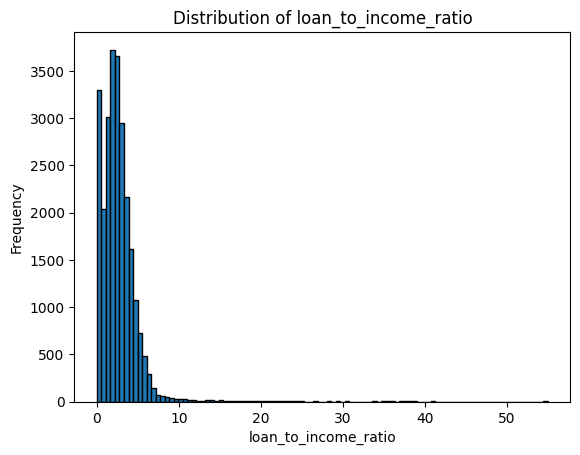

Skewness: 4.714908277858802


In [ ]:
# Log transformation
# Scaling

# 'loan_to_income_ratio'
plt.hist(train_df['loan_to_income_ratio'], bins=100, edgecolor='black')

plt.title('Distribution of loan_to_income_ratio')
plt.xlabel('loan_to_income_ratio')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of loan_to_income_ratio
original_skewness = skew(train_df['loan_to_income_ratio'])
print(f"Skewness: {original_skewness}")

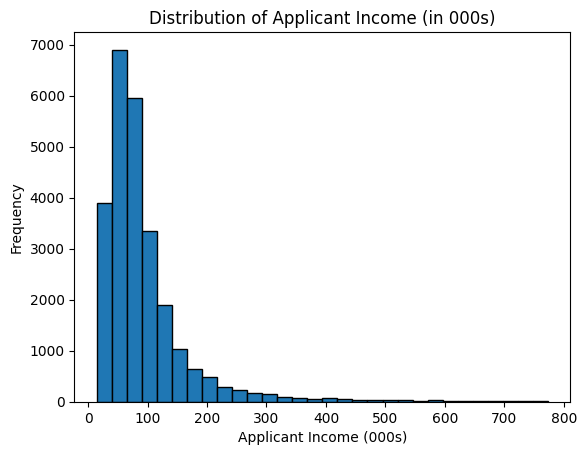

Skewness: 3.413777818361705


In [ ]:
# Log transformation: yes
# Scaling: yes


# applicant_income_000s
plt.hist(train_df['applicant_income_000s'], bins=30, edgecolor='black')

plt.title('Distribution of Applicant Income (in 000s)')
plt.xlabel('Applicant Income (000s)')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of applicant_income_000s
original_skewness = skew(train_df['applicant_income_000s'])
print(f"Skewness: {original_skewness}")

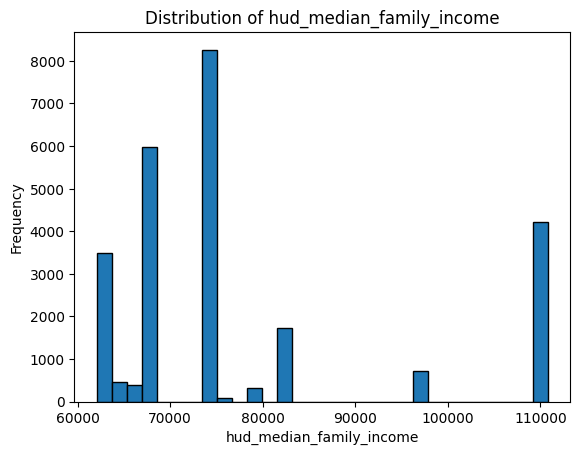

Skewness: 1.2566510670824513


In [ ]:
# Log transformation: No
# Scaling: yes

# hud_median_family_income
plt.hist(train_df['hud_median_family_income'], bins=30, edgecolor='black')

plt.title('Distribution of hud_median_family_income')
plt.xlabel('hud_median_family_income')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of hud_median_family_income
original_skewness = skew(train_df['hud_median_family_income'])
print(f"Skewness: {original_skewness}")

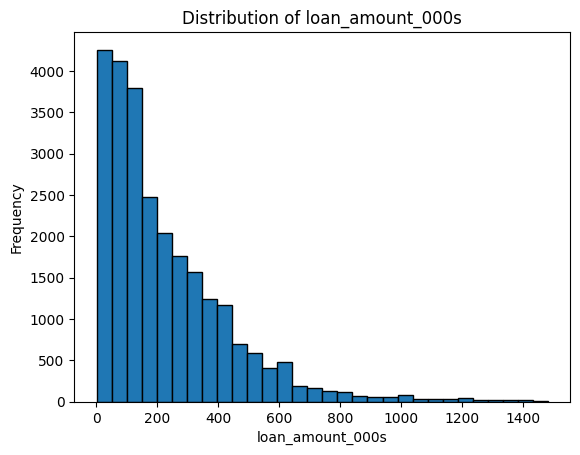

Skewness: 1.8358104832588578


In [ ]:
# Log transformation: yes
# scaling: yes

# loan_amount_000s
plt.hist(train_df['loan_amount_000s'], bins=30, edgecolor='black')

plt.title('Distribution of loan_amount_000s')
plt.xlabel('loan_amount_000s')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of loan_amount_000s
original_skewness = skew(train_df['loan_amount_000s'])
print(f"Skewness: {original_skewness}")

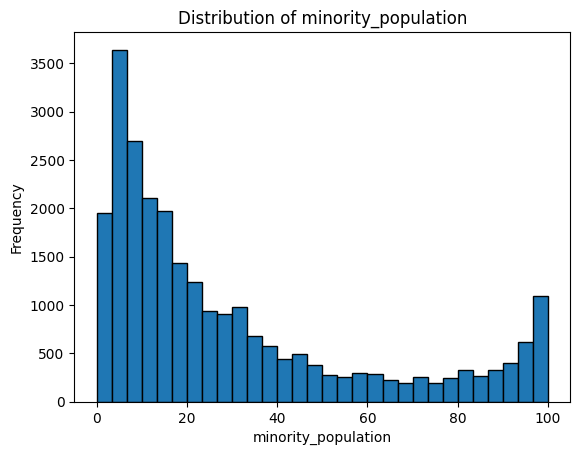

Skewness: 1.201782836622048


In [ ]:
# ONLY scaling.

# minority_population
plt.hist(train_df['minority_population'], bins=30, edgecolor='black')

plt.title('Distribution of minority_population')
plt.xlabel('minority_population')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of minority_population
original_skewness = skew(train_df['minority_population'])
print(f"Skewness: {original_skewness}")

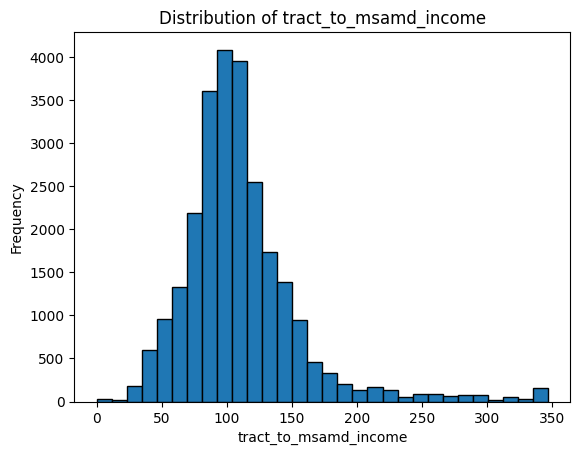

Skewness: 1.9775104739770033


In [ ]:
# Log transformation optional
# Scaling yes

# Applicant Income
plt.hist(train_df['tract_to_msamd_income'], bins=30, edgecolor='black')

plt.title('Distribution of tract_to_msamd_income')
plt.xlabel('tract_to_msamd_income')
plt.ylabel('Frequency')

plt.show()


# Calculating the skewness of tract_to_msamd_income
original_skewness = skew(train_df['tract_to_msamd_income'])
print(f"Skewness: {original_skewness}")

## C.2) Log Transformation
    'tract_to_msamd_income',
    'loan_amount_000s',
    'applicant_income_000s'

In [ ]:
columns_to_log = ['loan_to_income_ratio', 'tract_to_msamd_income', 'loan_amount_000s', 'applicant_income_000s']

train_df[columns_to_log] = train_df[columns_to_log].apply(np.log1p)
test_df[columns_to_log] = test_df[columns_to_log].apply(np.log1p)

## C.3) Scaling;
#### Standardization (Z-score normalization)

1) We want to avoid any leakage on from the training data into the test data, hence we will apply scaler and one-hot encoding separately (train_df - test_df)
2) We will first, Fit preprocessing steps on training data only.
3) Then we will apply preprocessing to both sets: we will use the parameters learned from the training data to transform both the training and test sets.

This approach ensures that:
1) The test set remains truly unseen during the training process.
2) Both training and test data are in the same format for model training and evaluation.
3) No information from the test set leaks into the preprocessing steps.

In [ ]:
# Features to Scale
columns_to_scaling = ['loan_to_income_ratio',
                    'applicant_income_000s',
                    'hud_median_family_income',
                    'loan_amount_000s',
                    'minority_population',
                    'tract_to_msamd_income'
                   ]

# Fit preprocessing on training data
scaler = StandardScaler()
scaler.fit(train_df[columns_to_scaling])

## Applying preprocessing to both sets
train_df[columns_to_scaling] = scaler.transform(train_df[columns_to_scaling])
test_df[columns_to_scaling] = scaler.transform(test_df[columns_to_scaling])

In [ ]:
# Check the mean and standard deviation
print("Means of scaled features:")
print(train_df[columns_to_scaling].mean())
print("\nStandard deviations of scaled features:")
print(train_df[columns_to_scaling].std())

Means of scaled features:
loan_to_income_ratio        4.552278e-17
applicant_income_000s      -4.566114e-16
hud_median_family_income   -1.103132e-16
loan_amount_000s           -5.024109e-16
minority_population         3.908871e-17
tract_to_msamd_income      -9.012887e-16
dtype: float64

Standard deviations of scaled features:
loan_to_income_ratio        1.000019
applicant_income_000s       1.000019
hud_median_family_income    1.000019
loan_amount_000s            1.000019
minority_population         1.000019
tract_to_msamd_income       1.000019
dtype: float64


In [ ]:
# Check the range max-min
print("\nMin values:")
print(train_df[columns_to_scaling].min())
print("\nMax values:")
print(train_df[columns_to_scaling].max())


Min values:
loan_to_income_ratio        -2.161826
applicant_income_000s       -2.503460
hud_median_family_income    -0.997934
loan_amount_000s            -2.987746
minority_population         -1.017062
tract_to_msamd_income      -11.398378
dtype: float64

Max values:
loan_to_income_ratio        5.501780
applicant_income_000s       3.691753
hud_median_family_income    2.049282
loan_amount_000s            2.009600
minority_population         2.421653
tract_to_msamd_income       2.981914
dtype: float64


## C.4) One-hot encoding

We follow the same approach as above,
1) We want to avoid any leakage on from the training data into the test data, hence we will apply scaler and one-hot encoding separately (train_df - test_df)
2) We will first, Fit preprocessing steps on training data only.
3) Then we will apply preprocessing to both sets: we will use the parameters learned from the training data to transform both the training and test sets.

This approach ensures that:
1) The test set remains truly unseen during the training process.
2) Both training and test data are in the same format for model training and evaluation.
3) No information from the test set leaks into the preprocessing steps. we use This approach ensures that:


##### OneHotEncoder vs get_dummies:
    OneHotEncoder and get_dummies are both used for one-hot encoding, but they have some differences:
1) OneHotEncoder (from scikit-learn):
    - Can be fit on training data and applied to test data separately
    - Handles unseen categories in test data (with 'handle_unknown' parameter)
    - Part of scikit-learn's preprocessing module, integrates well with pipelines
    - Can handle non-string categorical data easily
#####
2) get_dummies (from pandas):
    - Simpler to use for quick encoding of pandas DataFrames
    - Applies encoding immediately to the entire dataset
    - Doesn't handle unseen categories in new data by default
    - Works directly on pandas DataFrames and returns a DataFrame
#####
3) Main difference (which is why we are using OneHotEncoder) is:
    - OneHotEncoder is better for preventing data leakage and handling unseen categories in test data
    - get_dummies is more convenient for quick, one-time encoding of all data

In [ ]:
# Features to encode
categorical_columns = ['loan_type_name',
                             'loan_purpose_name',
                             'property_type_name',
                             'lien_status_name',
                             'ethnicity_race_sex']

# Fit preprocessing on training data only
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(train_df[categorical_columns])

# Applying preprocessing on both sets
train_df_LogEnco = encoder.transform(train_df[categorical_columns])
test_df_LogEnco = encoder.transform(test_df[categorical_columns])

# Creating new column names for the encoded features
new_column_names = encoder.get_feature_names_out(categorical_columns)

# Converting the encoded arrays to DataFrames
train_df_LogEnco = pd.DataFrame(train_df_LogEnco, columns=new_column_names, index=train_df.index)
test_df_LogEnco = pd.DataFrame(test_df_LogEnco, columns=new_column_names, index=test_df.index)

# Dropping the original categorical columns and add the encoded columns
train_df = train_df.drop(columns=categorical_columns).join(train_df_LogEnco)
test_df = test_df.drop(columns=categorical_columns).join(test_df_LogEnco)

#https://medium.com/@vinodkumargr/11-column-transformer-in-ml-sklearn-column-transformer-in-machine-learning-48479f8cb48f#:~:text=Scikit%2DLearn's%20Column%20Transformer%20is,transformer%20should%20be%20applied%20to.
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [ ]:
print(train_df)

        applicant_income_000s  hud_median_family_income  \
141721               1.016831                 -0.272108   
111851              -1.253297                 -0.972905   
49924               -1.855882                 -0.597478   
140179               0.407346                  0.316061   
90799               -0.748841                 -0.616250   
...                       ...                       ...   
19161                2.079194                 -0.272108   
57814                1.038709                 -0.272108   
40298                0.182515                 -0.272108   
100703              -0.392453                 -0.616250   
113190               0.144934                 -0.272108   

        hud_median_family_income_missing  loan_amount_000s  \
141721                                 0          0.928494   
111851                                 0         -0.499762   
49924                                  0         -0.631871   
140179                                 0   

In [ ]:
print(train_df.isnull().sum())

applicant_income_000s                                                                         0
hud_median_family_income                                                                      0
hud_median_family_income_missing                                                              0
loan_amount_000s                                                                              0
loan_to_income_ratio                                                                          0
minority_population                                                                           0
minority_population_missing                                                                   0
tract_to_msamd_income                                                                         0
tract_to_msamd_income_missing                                                                 0
action_taken_binary                                                                           0
loan_type_name_Conventional             

# D) Define features and target variable:

    We separate the features (X) and target variable (y) for both train and test sets.

In [ ]:
features =[    'action_taken_binary',
                #'applicant_income_000s',
                'hud_median_family_income',
                'hud_median_family_income_missing',
                #'loan_amount_000s',
                'loan_to_income_ratio',
                'minority_population',
                'minority_population_missing',
                'tract_to_msamd_income',
                'tract_to_msamd_income_missing',
                'loan_type_name_Conventional',
                'loan_type_name_FHA-insured',
                'loan_type_name_FSA/RHS-guaranteed',
                'loan_type_name_VA-guaranteed',
                'loan_purpose_name_Home improvement',
                'loan_purpose_name_Home purchase',
                'loan_purpose_name_Refinancing',
                'property_type_name_Manufactured housing',
                'property_type_name_Multifamily dwelling',
                'property_type_name_One-to-four family dwelling (other than manufactured housing)',
                'lien_status_name_Not secured by a lien',
                'lien_status_name_Secured by a first lien',
                'lien_status_name_Secured by a subordinate lien',
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_hispanic or latino_asian_female",
                "ethnicity_race_sex_hispanic or latino_asian_male",
                "ethnicity_race_sex_hispanic or latino_black or african american_female",
                "ethnicity_race_sex_hispanic or latino_black or african american_male",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_hispanic or latino_white_female",
                "ethnicity_race_sex_hispanic or latino_white_male",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_not hispanic or latino_asian_female",
                "ethnicity_race_sex_not hispanic or latino_asian_male",
                "ethnicity_race_sex_not hispanic or latino_black or african american_female",
                "ethnicity_race_sex_not hispanic or latino_black or african american_male",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_not hispanic or latino_white_female",
                'ethnicity_race_sex_not hispanic or latino_white_male'
           ]


train_df = train_df[features]
test_df = test_df[features]

In [ ]:
# Train set
X_train = train_df.drop('action_taken_binary', axis=1)
y_train = train_df['action_taken_binary']

# Test Set
X_test = test_df.drop('action_taken_binary', axis=1)
y_test = test_df['action_taken_binary']

In [ ]:
# Checking the shapes of the resulting splits
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (25676, 40)
y_train shape: (25676,)
X_test shape: (11004, 40)
y_test shape: (11004,)


# E) Bias measurement:
##### We measure biases BEFORE smote with AIF360. We use Disparate Impact as measurement.
1) First, we'll create a single categorical column from the 20 one-hot encoded ethnicity-race-sex columns. This new column will be our protected attribute.
2) We'll use the BinaryLabelDataset from AIF360, specifying 'action_taken_binary' as the target and our new categorical column as the protected attribute.
3) We'll use BinaryLabelDatasetMetric to compute metrics for each group, focusing on disparate impact and statistical parity difference.
4) We'll examine the metrics for each ethnicity-race-sex group and identify any groups facing significantly higher rejection rates.

### Privileged class:
Since we are interested on disparities within our dataset, we will use the most "populous class" (privieged class) as benchmarking

In [ ]:
print(train_df['ethnicity_race_sex_not hispanic or latino_white_male'])

141721    1.0
111851    1.0
49924     0.0
140179    1.0
90799     1.0
         ... 
19161     1.0
57814     0.0
40298     0.0
100703    1.0
113190    1.0
Name: ethnicity_race_sex_not hispanic or latino_white_male, Length: 25676, dtype: float64


## E.1) Dataset creation

In [ ]:
# Define variables:
protected_attribute_names=[
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_hispanic or latino_asian_female",
                "ethnicity_race_sex_hispanic or latino_asian_male",
                "ethnicity_race_sex_hispanic or latino_black or african american_female",
                "ethnicity_race_sex_hispanic or latino_black or african american_male",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_hispanic or latino_white_female",
                "ethnicity_race_sex_hispanic or latino_white_male",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_not hispanic or latino_asian_female",
                "ethnicity_race_sex_not hispanic or latino_asian_male",
                "ethnicity_race_sex_not hispanic or latino_black or african american_female",
                "ethnicity_race_sex_not hispanic or latino_black or african american_male",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_not hispanic or latino_white_female",
                'ethnicity_race_sex_not hispanic or latino_white_male' #notice we inlcude the privilege group
                            ]

favorable_label = 0  # loan approved
unfavorable_label = 1  # loan denied

# First, we create the dataset
aif_dataset = BinaryLabelDataset(
    df=train_df,
    label_names=['action_taken_binary'],
    protected_attribute_names=protected_attribute_names,
    favorable_label = favorable_label,  # loan approved
    unfavorable_label = unfavorable_label  # loan denied

                                )

#https://www.rdocumentation.org/packages/aif360/versions/0.1.0/topics/aif_dataset
#https://aif360.readthedocs.io/en/latest/
#

## E.2) Defining groups

In [ ]:
# Defining privileged group directly
privileged_groups = [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]

# Defining unprivileged groups using a loop
unprivileged_groups = []
for attribute in protected_attribute_names:
    if attribute != 'ethnicity_race_sex_not hispanic or latino_white_male':
        unprivileged_groups.append({attribute: 1})

# Checking the groups
print("Privileged group:", privileged_groups)
print("Number of unprivileged groups:", len(unprivileged_groups))
print("First few unprivileged groups:", unprivileged_groups[:3])

Privileged group: [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]
Number of unprivileged groups: 19
First few unprivileged groups: [{'ethnicity_race_sex_hispanic or latino_american indian or alaska native_female': 1}, {'ethnicity_race_sex_hispanic or latino_american indian or alaska native_male': 1}, {'ethnicity_race_sex_hispanic or latino_asian_female': 1}]


## E.3) Metrics

In [ ]:
# Calculating metrics
metric = BinaryLabelDatasetMetric(aif_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

In [ ]:
# Printing metrics
print(f"Disparate Impact: {metric.disparate_impact():.4f}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")

# We calculate and print the mean difference in label predictions
print(f"Mean difference in label predictions: {metric.mean_difference():.4f}")

# Calculating group-specific metrics
for group in unprivileged_groups:
    group_metric = BinaryLabelDatasetMetric(aif_dataset,
                                            unprivileged_groups=[group],
                                            privileged_groups=privileged_groups)

    group_name = list(group.keys())[0]
    print(f"\nGroup: {group_name}")
    print(f"Disparate Impact: {group_metric.disparate_impact():.4f}")
    print(f"Statistical Parity Difference: {group_metric.statistical_parity_difference():.4f}")

#https://stackoverflow.com/questions/67044157/create-a-sublist-from-list-of-dictionaries
#https://text-models.readthedocs.io/en/latest/_modules/text_models/vocabulary.html

Disparate Impact: 0.9659
Statistical Parity Difference: -0.0275
Mean difference in label predictions: -0.0275

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_female
Disparate Impact: 0.4650
Statistical Parity Difference: -0.4315

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_male
Disparate Impact: 0.5636
Statistical Parity Difference: -0.3519

Group: ethnicity_race_sex_hispanic or latino_asian_female
Disparate Impact: 0.8267
Statistical Parity Difference: -0.1398

Group: ethnicity_race_sex_hispanic or latino_asian_male
Disparate Impact: 0.6975
Statistical Parity Difference: -0.2440

Group: ethnicity_race_sex_hispanic or latino_black or african american_female
Disparate Impact: 0.7647
Statistical Parity Difference: -0.1898

Group: ethnicity_race_sex_hispanic or latino_black or african american_male
Disparate Impact: 0.6200
Statistical Parity Difference: -0.3065

Group: ethnicity_race_sex_hispanic or latino_native hawaiian or

# F) SMOTE

Application for our unbalanced data.

In [ ]:
#Initializing SMOTE
smote = SMOTE(random_state=42)

# Application of SMOTE only on the training set to balance the classes
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the distribution of the target variable after SMOTE
print("Before SMOTE:", y_train.value_counts())
print("\n After SMOTE:", y_train_smote.value_counts())


Before SMOTE: action_taken_binary
0    20314
1     5362
Name: count, dtype: int64

 After SMOTE: action_taken_binary
0    20314
1    20314
Name: count, dtype: int64


## F.1) Bias AFTER SMOTE

We measure biases after SMOTE application

### F.1.1) First

We resamble the dataset.

In [ ]:
# Converting the resampled X_train and y_train into a DataFrame
X_train_s = pd.DataFrame(X_train_smote, columns=X_train.columns)  # We retained original column names
y_train_s = pd.DataFrame(y_train_smote, columns=['action_taken_binary'])

# Combining X and y into a single DataFrame
train_df_smote = pd.concat([X_train_s, y_train_s], axis=1)

### F.1.2) Second
We use the resambled dataset to apply the same procces used earlier and assess any difference.

In [ ]:
# Defining variables:
protected_attribute_names=[
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_hispanic or latino_asian_female",
                "ethnicity_race_sex_hispanic or latino_asian_male",
                "ethnicity_race_sex_hispanic or latino_black or african american_female",
                "ethnicity_race_sex_hispanic or latino_black or african american_male",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_hispanic or latino_white_female",
                "ethnicity_race_sex_hispanic or latino_white_male",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_not hispanic or latino_asian_female",
                "ethnicity_race_sex_not hispanic or latino_asian_male",
                "ethnicity_race_sex_not hispanic or latino_black or african american_female",
                "ethnicity_race_sex_not hispanic or latino_black or african american_male",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_not hispanic or latino_white_female",
                'ethnicity_race_sex_not hispanic or latino_white_male' #notice we inlcude the privilege group
                            ]

favorable_label = 0  # loan approved
unfavorable_label = 1  # loan denied

# Creating the dataset
aif_dataset = BinaryLabelDataset(
    df=train_df_smote,
    label_names=['action_taken_binary'],
    protected_attribute_names=protected_attribute_names,
    favorable_label = favorable_label,  # loan approved
    unfavorable_label = unfavorable_label  # loan denied

                                )

In [ ]:
# Definining privileged group directly
privileged_groups = [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]

# Defining unprivileged groups using a loop
unprivileged_groups = []
for attribute in protected_attribute_names:
    if attribute != 'ethnicity_race_sex_not hispanic or latino_white_male':
        unprivileged_groups.append({attribute: 1})

# Checking the groups for verification
print("Privileged group:", privileged_groups)
print("Number of unprivileged groups:", len(unprivileged_groups))
print("First few unprivileged groups:", unprivileged_groups[:3])

Privileged group: [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]
Number of unprivileged groups: 19
First few unprivileged groups: [{'ethnicity_race_sex_hispanic or latino_american indian or alaska native_female': 1}, {'ethnicity_race_sex_hispanic or latino_american indian or alaska native_male': 1}, {'ethnicity_race_sex_hispanic or latino_asian_female': 1}]


In [ ]:
# Calculating metrics
metric = BinaryLabelDatasetMetric(aif_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

In [ ]:
# Printing metrics
print(f"Disparate Impact: {metric.disparate_impact():.4f}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")

# We calculate and print the mean difference in label predictions
print(f"Mean difference in label predictions: {metric.mean_difference():.4f}")

# Calculating group-specific metrics
for group in unprivileged_groups:
    group_metric = BinaryLabelDatasetMetric(aif_dataset,
                                            unprivileged_groups=[group],
                                            privileged_groups=privileged_groups)

    group_name = list(group.keys())[0]
    print(f"\nGroup: {group_name}")
    print(f"Disparate Impact: {group_metric.disparate_impact():.4f}")
    print(f"Statistical Parity Difference: {group_metric.statistical_parity_difference():.4f}")

Disparate Impact: 0.9720
Statistical Parity Difference: -0.0146
Mean difference in label predictions: -0.0146

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_female
Disparate Impact: 0.6381
Statistical Parity Difference: -0.1890

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_male
Disparate Impact: 0.5318
Statistical Parity Difference: -0.2446

Group: ethnicity_race_sex_hispanic or latino_asian_female
Disparate Impact: 1.2762
Statistical Parity Difference: 0.1443

Group: ethnicity_race_sex_hispanic or latino_asian_male
Disparate Impact: 0.9068
Statistical Parity Difference: -0.0487

Group: ethnicity_race_sex_hispanic or latino_black or african american_female
Disparate Impact: 1.0416
Statistical Parity Difference: 0.0217

Group: ethnicity_race_sex_hispanic or latino_black or african american_male
Disparate Impact: 0.6110
Statistical Parity Difference: -0.2032

Group: ethnicity_race_sex_hispanic or latino_native hawaiian or o

# G) Reweighting

In [ ]:
# AIF360 dataset
aif_dataset = BinaryLabelDataset(
    df=train_df_smote,  # Use the SMOTE data you have
    label_names=['action_taken_binary'],
    protected_attribute_names=protected_attribute_names,
    favorable_label=favorable_label,  # loan approved
    unfavorable_label=unfavorable_label  # loan denied
)

# Defining privileged and unprivileged groups
privileged_groups = [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]
unprivileged_groups = []
for attribute in protected_attribute_names:
    if attribute != 'ethnicity_race_sex_not hispanic or latino_white_male':
        unprivileged_groups.append({attribute: 1})

# Applying the Reweighing algorithm
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

# Fitting the "reweighing model". Transforming the dataset
reweighted_dataset = RW.fit_transform(aif_dataset)

# Turning the reweighted data back to pandas to use with our logistic regression model
reweighted_df = reweighted_dataset.convert_to_dataframe()[0]

# Re-defining variables
X_train_reweighted = reweighted_df.drop(columns=['action_taken_binary'])
y_train_reweighted = reweighted_df['action_taken_binary']

# H) LightGBM

In [ ]:
# We start the model
lgbm_model = lgbm.LGBMClassifier(random_state=42)

# Training (fitting) the model on the training data
lgbm_model.fit(X_train_reweighted, y_train_reweighted)

# After training, we evaluate the model on the test set
# Making preditions
y_pred = lgbm_model.predict(X_test)
y_pred_proba = lgbm_model.predict_proba(X_test)[:, 1]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 20314, number of negative: 20314
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2557
[LightGBM] [Info] Number of data points in the train set: 40628, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [ ]:
# Model performance evaluation:

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Negative log loss
neg_log_loss = log_loss(y_test, y_pred_proba)

# Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Negative Log Loss: {neg_log_loss:.4f}")

Accuracy: 0.7347
Precision: 0.3771
Recall: 0.4894
F1 Score: 0.4260
ROC-AUC: 0.7120
Negative Log Loss: 0.5355


In [ ]:
# For each group we will print in descendent order the different metrics

# Adding the predicted values to a new test set for evaluation
X_test_with_pred = X_test.copy()
X_test_with_pred['y_test'] = y_test  # Columns for y_test and y_pred.
X_test_with_pred['y_pred'] = y_pred

# Predicted probabilities for class 1 (default)
X_test_with_pred['y_pred_proba'] = lgbm_model.predict_proba(X_test)[:, 1]

# List of intersectional group columns
ethnicity_race_sex_cols = [col for col in X_test_with_pred.columns if col.startswith('ethnicity_race_sex')]

# Creation of a column where each row represents an intersectional group
X_test_with_pred['intersectional_group'] = X_test_with_pred[ethnicity_race_sex_cols].idxmax(axis=1)

# Groupping by the intersectional group to evaluate the model performance for each intersectional group
grouped = X_test_with_pred.groupby('intersectional_group')

# Evaluation of the metrics for each group
for group_name, group_data in grouped:
    accuracy = accuracy_score(group_data['y_test'], group_data['y_pred'])
    precision = precision_score(group_data['y_test'], group_data['y_pred'], zero_division=0)
    recall = recall_score(group_data['y_test'], group_data['y_pred'], zero_division=0)
    f1 = f1_score(group_data['y_test'], group_data['y_pred'], zero_division=0)
# It happened that roc_auc had only one class for certain groups (as neg_log_loss), therefore, we check
# if both classes (0 and 1) are present in "y_test" before calculating ROC AUC(and neg_log_loss)
    if len(np.unique(group_data['y_test'])) > 1:
        roc_auc = roc_auc_score(group_data['y_test'], group_data['y_pred_proba'])
    else:
        roc_auc = None

    # Checking which classes are present
    if len(np.unique(group_data['y_test'])) > 1:
        neg_log_loss = log_loss(group_data['y_test'], group_data['y_pred_proba'])
    else:
        neg_log_loss = None  #


    print(f"# Group: {group_name}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

    if roc_auc is not None:
        print(f"  ROC-AUC: {roc_auc:.4f}")
    else:
        print(f"  ROC-AUC: Not defined (only one class present)")

    # Handling case where log loss is not computed
    if neg_log_loss is not None:
        print(f"  Negative Log Loss: {neg_log_loss:.4f}")
    else:
        print(f"  Negative Log Loss: Not defined (only one class present)")

    print("\n" + "-"*50 + "\n")

# Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_female
  Accuracy: 0.7143
  Precision: 0.5000
  Recall: 1.0000
  F1 Score: 0.6667
  ROC-AUC: 0.8000
  Negative Log Loss: 0.5756

--------------------------------------------------

# Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_male
  Accuracy: 0.6364
  Precision: 0.5714
  Recall: 0.8000
  F1 Score: 0.6667
  ROC-AUC: 0.8333
  Negative Log Loss: 0.5305

--------------------------------------------------

# Group: ethnicity_race_sex_hispanic or latino_asian_female
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  ROC-AUC: 1.0000
  Negative Log Loss: 0.1909

--------------------------------------------------

# Group: ethnicity_race_sex_hispanic or latino_asian_male
  Accuracy: 0.4286
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
  ROC-AUC: 0.0000
  Negative Log Loss: 0.7625

--------------------------------------------------

# Group: ethni

# I) Bias measurement:
1) We use Disparate Impact as a method to measure biases

2) We re-join X_test and y_pred

In [ ]:
# We got many empty rows due to index misalignment, so we need to reset index for both df:
# X_test and y_pred
X_test_reset = X_test.reset_index(drop=True)
y_pred_reset = pd.DataFrame(y_pred, columns=['action_taken_binary']).reset_index(drop=True)

# Concatenating the two DataFrames
lgbm_trained_df = pd.concat([X_test_reset, y_pred_reset], axis=1)

In [ ]:
# Defining variables:
protected_attribute_names=[
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_hispanic or latino_asian_female",
                "ethnicity_race_sex_hispanic or latino_asian_male",
                "ethnicity_race_sex_hispanic or latino_black or african american_female",
                "ethnicity_race_sex_hispanic or latino_black or african american_male",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_hispanic or latino_white_female",
                "ethnicity_race_sex_hispanic or latino_white_male",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_female",
                "ethnicity_race_sex_not hispanic or latino_american indian or alaska native_male",
                "ethnicity_race_sex_not hispanic or latino_asian_female",
                "ethnicity_race_sex_not hispanic or latino_asian_male",
                "ethnicity_race_sex_not hispanic or latino_black or african american_female",
                "ethnicity_race_sex_not hispanic or latino_black or african american_male",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_female",
                "ethnicity_race_sex_not hispanic or latino_native hawaiian or other pacific islander_male",
                "ethnicity_race_sex_not hispanic or latino_white_female",
                'ethnicity_race_sex_not hispanic or latino_white_male' #notice we inlcude the privilege group
                            ]

favorable_label = 0  # loan approved
unfavorable_label = 1  # loan denied

# Creating the dataset
aif_dataset = BinaryLabelDataset(
    df=lgbm_trained_df,
    label_names=['action_taken_binary'],
    protected_attribute_names=protected_attribute_names,
    favorable_label = favorable_label,  # loan approved
    unfavorable_label = unfavorable_label  # loan denied

                                )

In [ ]:
# Definition of the privileged group directly
privileged_groups = [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]

# Defining unprivileged groups using a loop
unprivileged_groups = []
for attribute in protected_attribute_names:
    if attribute != 'ethnicity_race_sex_not hispanic or latino_white_male':
        unprivileged_groups.append({attribute: 1})

# Checking groups
print("Privileged group:", privileged_groups)
print("Number of unprivileged groups:", len(unprivileged_groups))
print("First few unprivileged groups:", unprivileged_groups[:3])

Privileged group: [{'ethnicity_race_sex_not hispanic or latino_white_male': 1}]
Number of unprivileged groups: 19
First few unprivileged groups: [{'ethnicity_race_sex_hispanic or latino_american indian or alaska native_female': 1}, {'ethnicity_race_sex_hispanic or latino_american indian or alaska native_male': 1}, {'ethnicity_race_sex_hispanic or latino_asian_female': 1}]


In [ ]:
# Calculating metrics
metric = BinaryLabelDatasetMetric(aif_dataset,
                                  unprivileged_groups=unprivileged_groups,
                                  privileged_groups=privileged_groups)

In [ ]:
# Printing metrics
print(f"Disparate Impact: {metric.disparate_impact():.4f}")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")

# We calculate and print the mean difference in label predictions
print(f"Mean difference in label predictions: {metric.mean_difference():.4f}")

# Calculating group-specific metrics
for group in unprivileged_groups:
    group_metric = BinaryLabelDatasetMetric(aif_dataset,
                                            unprivileged_groups=[group],
                                            privileged_groups=privileged_groups)

    group_name = list(group.keys())[0]
    print(f"\nGroup: {group_name}")
    print(f"Disparate Impact: {group_metric.disparate_impact():.4f}")
    print(f"Statistical Parity Difference: {group_metric.statistical_parity_difference():.4f}")

Disparate Impact: 0.9558
Statistical Parity Difference: -0.0335
Mean difference in label predictions: -0.0335

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_female
Disparate Impact: 0.5655
Statistical Parity Difference: -0.3293

Group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_male
Disparate Impact: 0.4798
Statistical Parity Difference: -0.3942

Group: ethnicity_race_sex_hispanic or latino_asian_female
Disparate Impact: 0.6598
Statistical Parity Difference: -0.2579

Group: ethnicity_race_sex_hispanic or latino_asian_male
Disparate Impact: 0.7540
Statistical Parity Difference: -0.1864

Group: ethnicity_race_sex_hispanic or latino_black or african american_female
Disparate Impact: 0.8397
Statistical Parity Difference: -0.1215

Group: ethnicity_race_sex_hispanic or latino_black or african american_male
Disparate Impact: 0.4618
Statistical Parity Difference: -0.4079

Group: ethnicity_race_sex_hispanic or latino_native hawaiian or

# J) SHAP

## J.1) Overall model assessment

In [ ]:
# lgbm_model.fit(X_train_smote, y_train_smote)
# lgbm_model = lgb.LGBMClassifier(random_state=42)

# Creating SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgbm_model, X_train_reweighted)

# Calculating SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Calculating mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Creating a DataFrame with feature names and mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap
})

# Sorting by importance
shap_importance_sorted = shap_importance.sort_values(by='importance', ascending=False)


 98%|===================| 10732/11004 [00:37<00:00]       

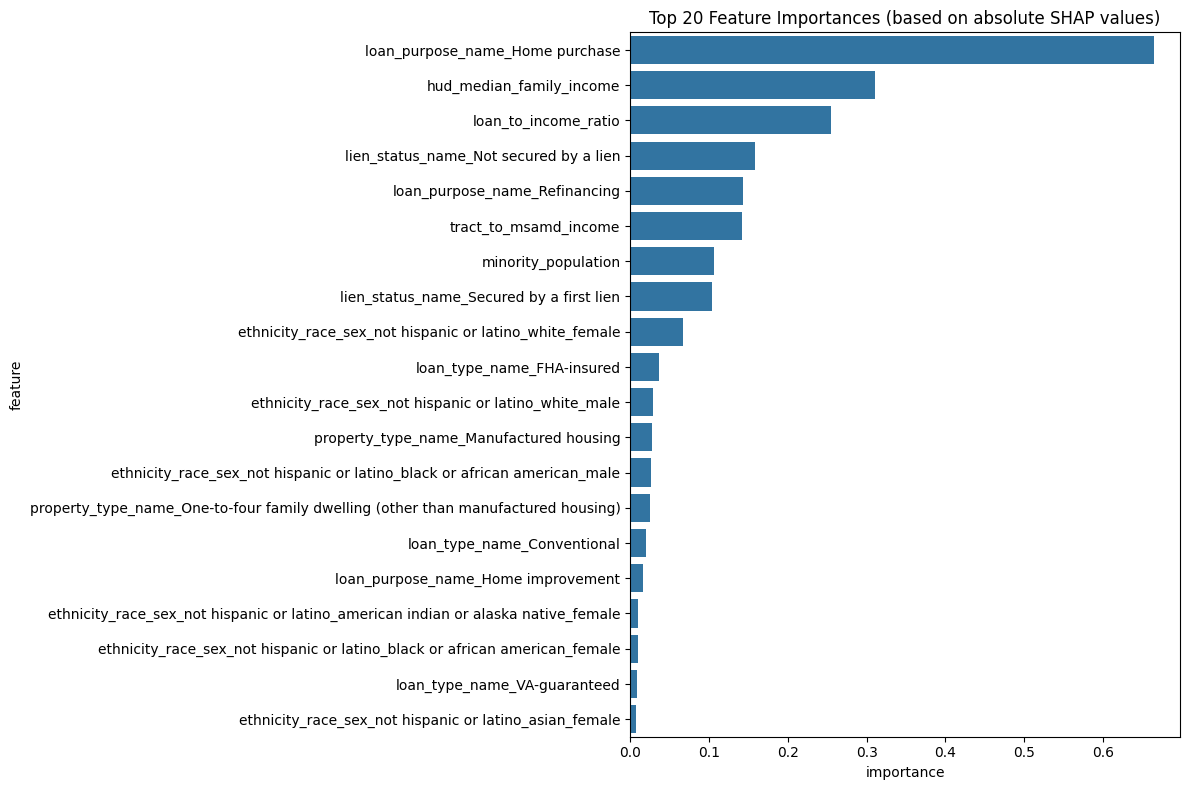

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


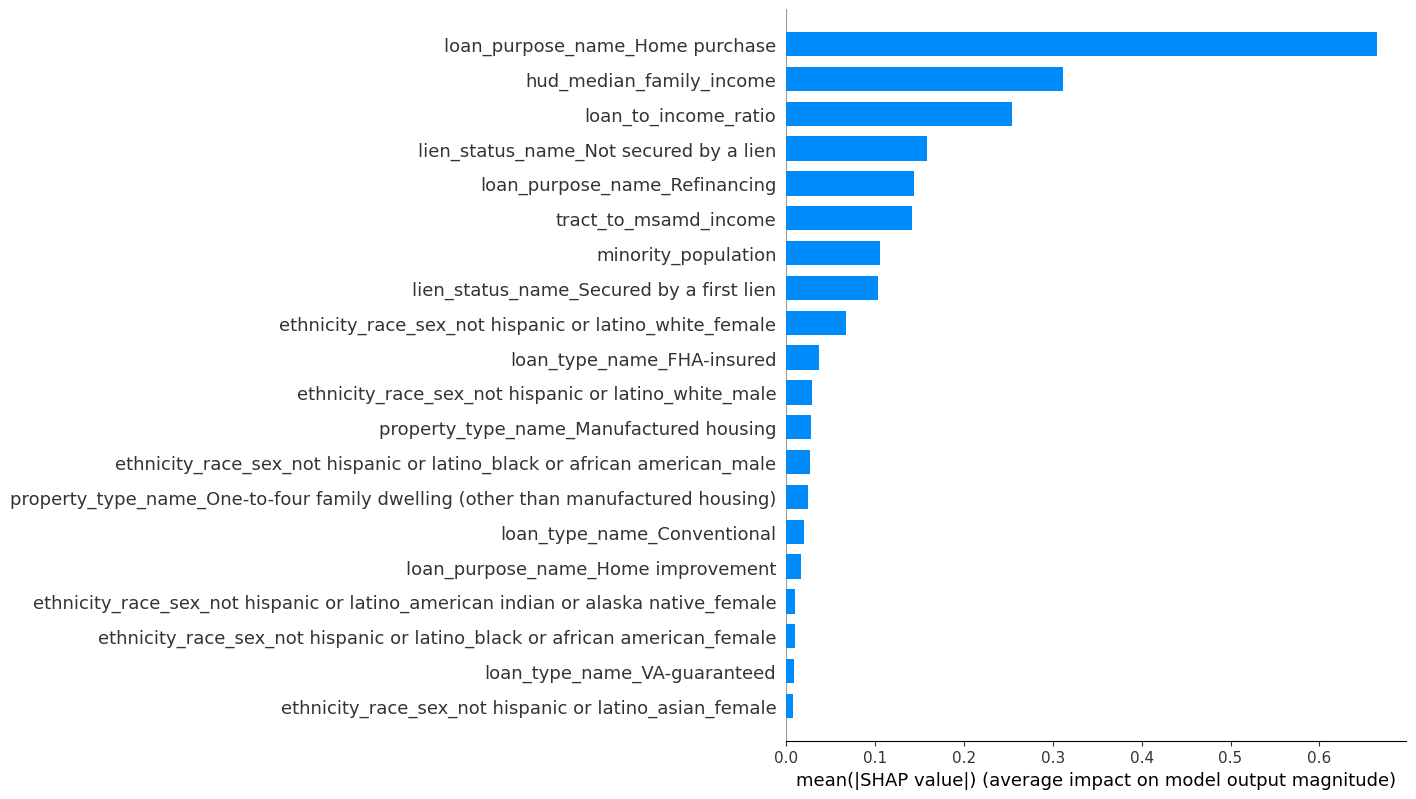

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


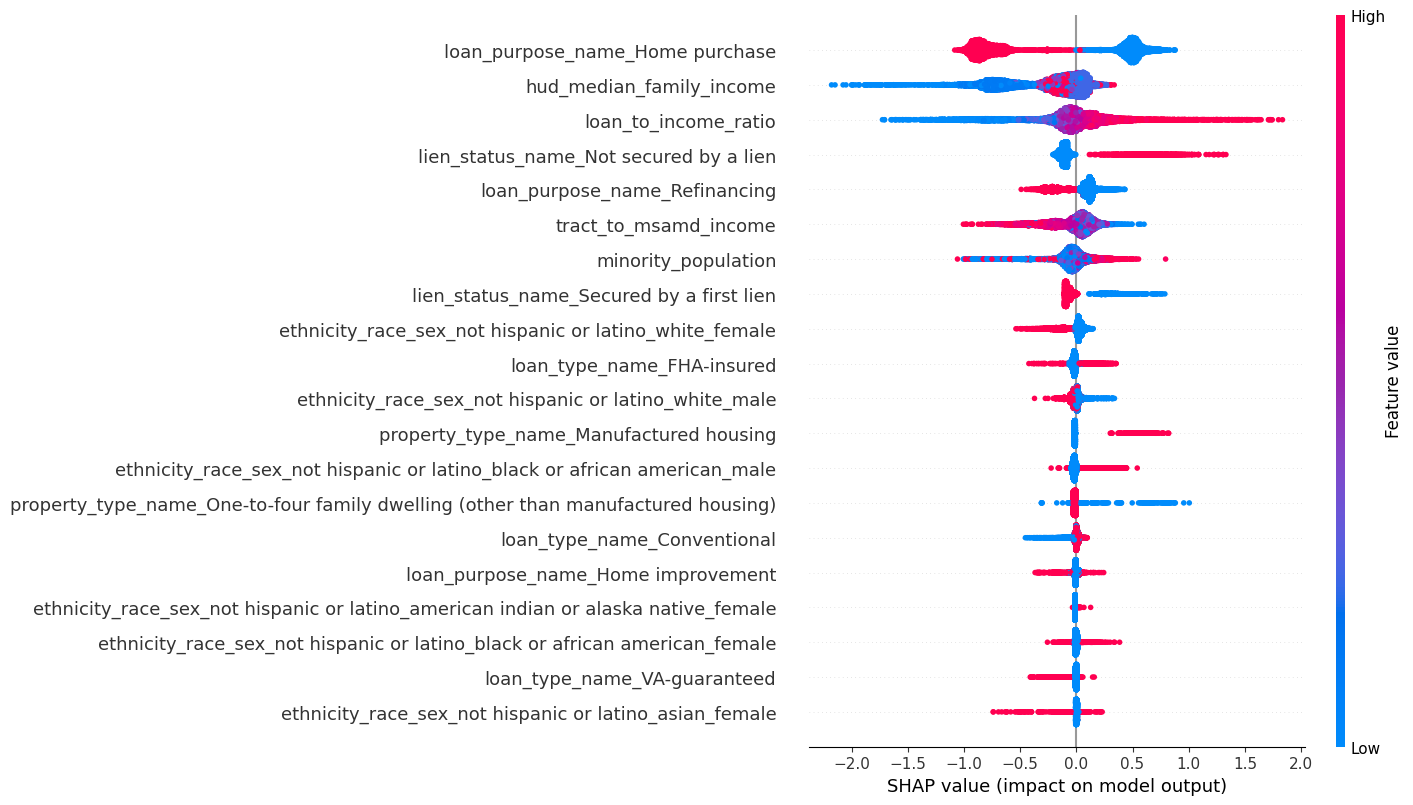

In [ ]:
# Bar Plot for Top 20 Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=shap_importance_sorted.head(20))
plt.title('Top 20 Feature Importances (based on absolute SHAP values)')
plt.tight_layout()
plt.show()

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# Detailed Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)
plt.show()

In [ ]:
# lgbm_model.fit(X_train_smote, y_train_smote)
# lgbm_model = lgb.LGBMClassifier(random_state=42)

# Creating SHAP explainer for LightGBM
explainer = shap.TreeExplainer(lgbm_model, X_train_reweighted)

# Calculating SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Calculating mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)

# Creating a DataFrame with feature names and mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap
})

# Sorting by importance
shap_importance_sorted = shap_importance.sort_values(by='importance', ascending=False)


 98%|===================| 10730/11004 [00:37<00:00]       

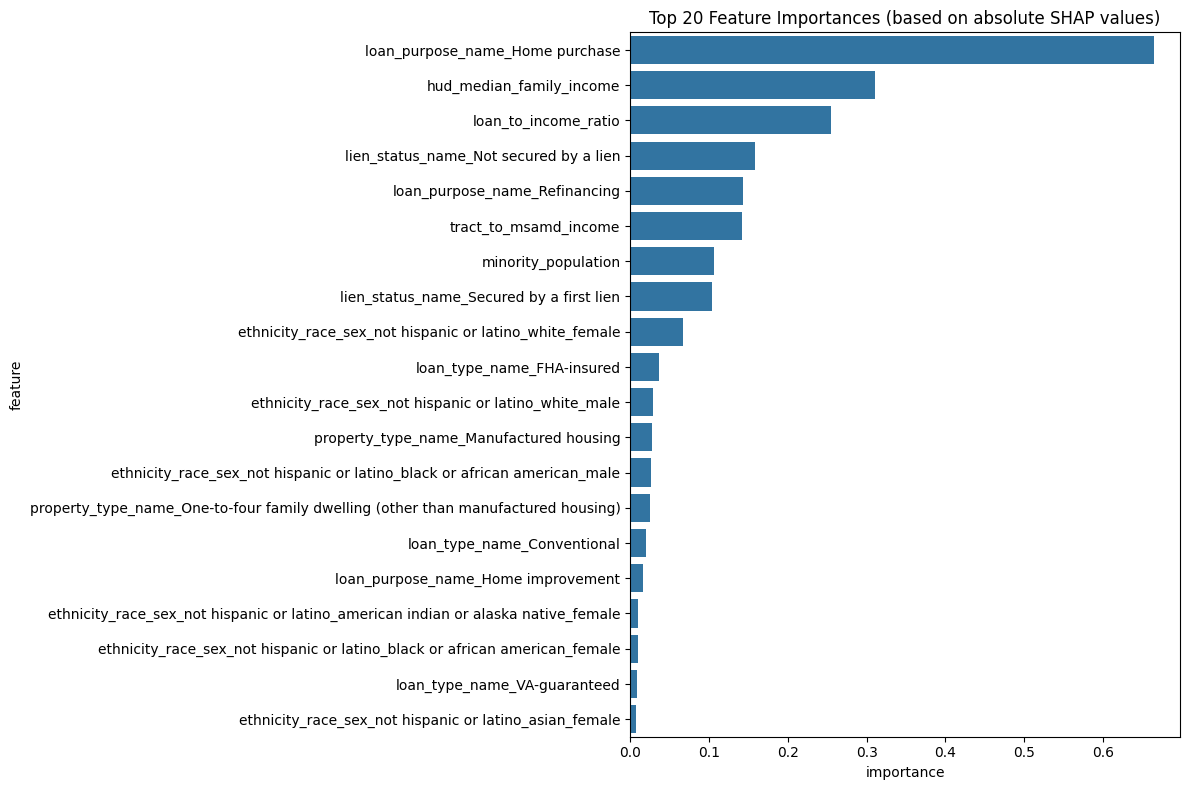

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


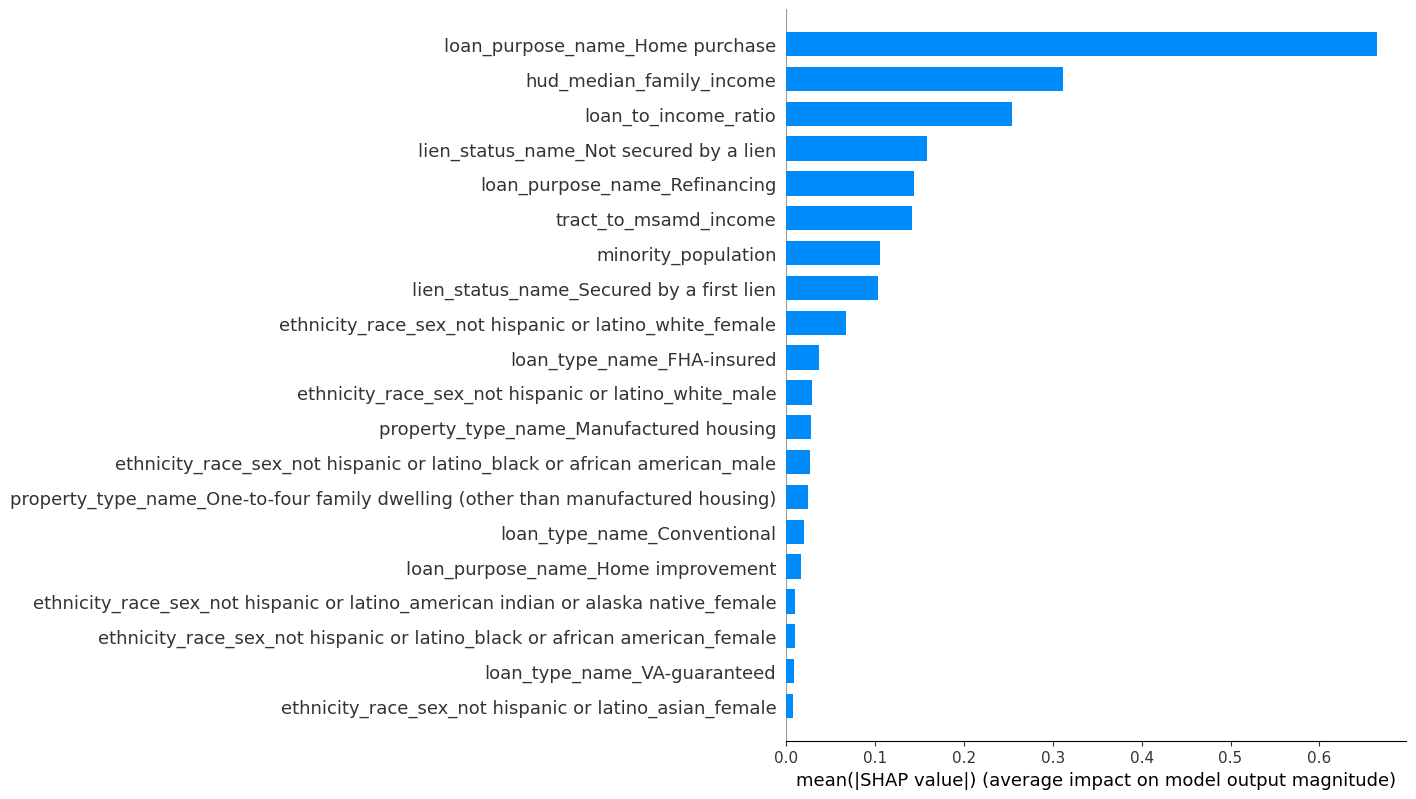

/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


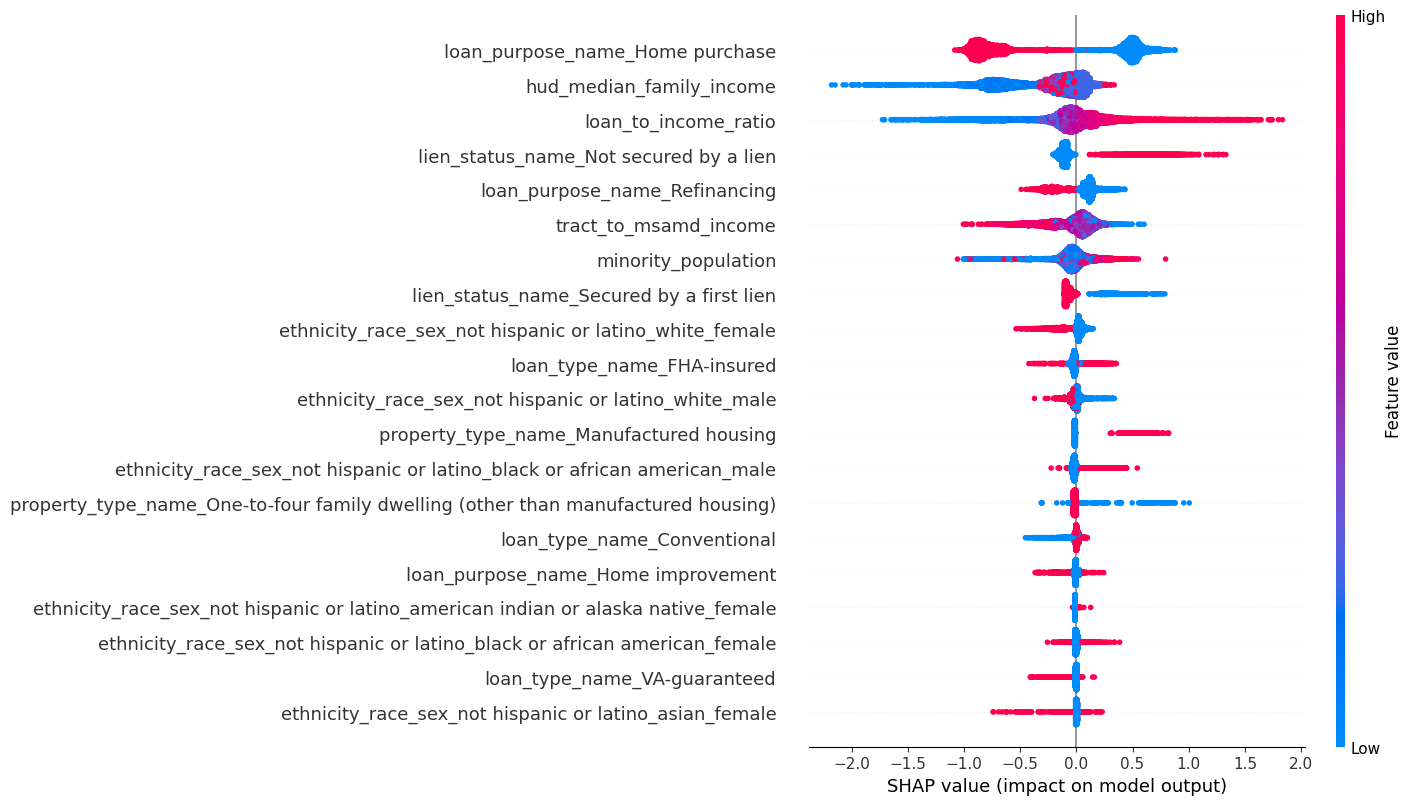

In [ ]:
# Bar Plot for Top 20 Feature Importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=shap_importance_sorted.head(20))
plt.title('Top 20 Feature Importances (based on absolute SHAP values)')
plt.tight_layout()
plt.show()

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

# Detailed Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)
plt.show()

## J.2) WaterFall plot per group.

In [ ]:
# List of the intersectional group columns
ethnicity_race_sex_cols = [col for col in X_test_with_pred.columns if col.startswith('ethnicity_race_sex')]

# Creating a column that represents each intersectional group
X_test_with_pred['intersectional_group'] = X_test_with_pred[ethnicity_race_sex_cols].idxmax(axis=1)

# Reseting the index of X_test_with_pred and X_test to ensure they match shap_values (we had issues earlier without resetting)
X_test_with_pred = X_test_with_pred.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# Grouping by intersectional group to evaluate SHAP values for each group
grouped = X_test_with_pred.groupby('intersectional_group')

# Loop through each intersectional group
for group_name, group_data in grouped:
    print(f"Generating SHAP Waterfall plot for group: {group_name}")

    # Getting the subset of the data for this intersectional group
    X_group = X_test.loc[group_data.index]

    # Creation of a subset for the SHAP values for this group
    shap_values_group = shap_values[group_data.index]  # This bit ensure that SHAP values match X_group

    # Picking a specific row to explain for the waterfall plot
    row_to_explain = group_data.index[0]

     # We generate the SHAP waterfall plot for a single prediction in this group
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values[row_to_explain],  # SHAP values for the specific row
            base_values=explainer.expected_value,  # Base value for the SHAP model
            data=X_test.iloc[row_to_explain, :],  # Input data for the specific row
            feature_names=X_test.columns  # Feature names
        )
    )


Output hidden; open in https://colab.research.google.com to view.

## J.3) Summary per group

Generating SHAP Summary plot for group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_female


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


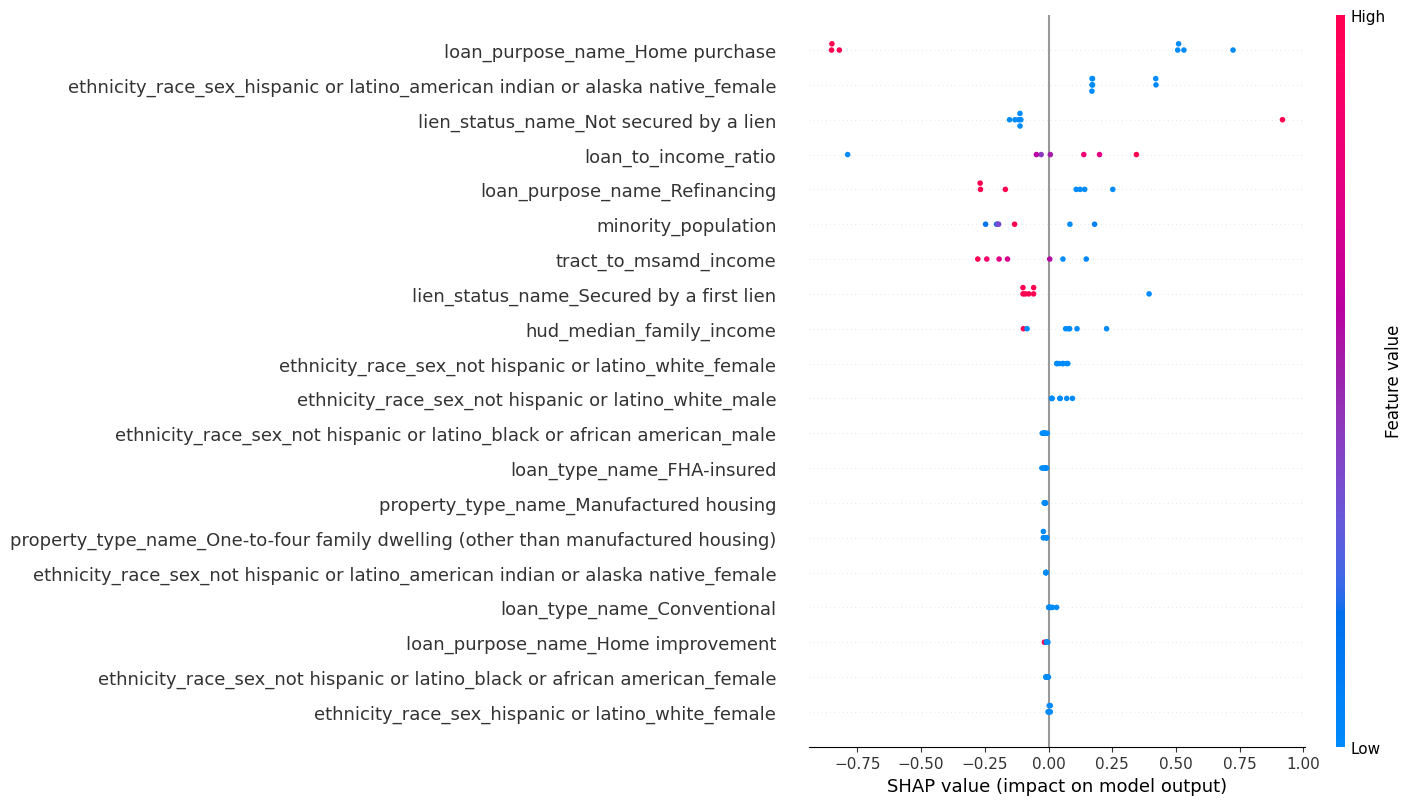

Generating SHAP Summary plot for group: ethnicity_race_sex_hispanic or latino_american indian or alaska native_male


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


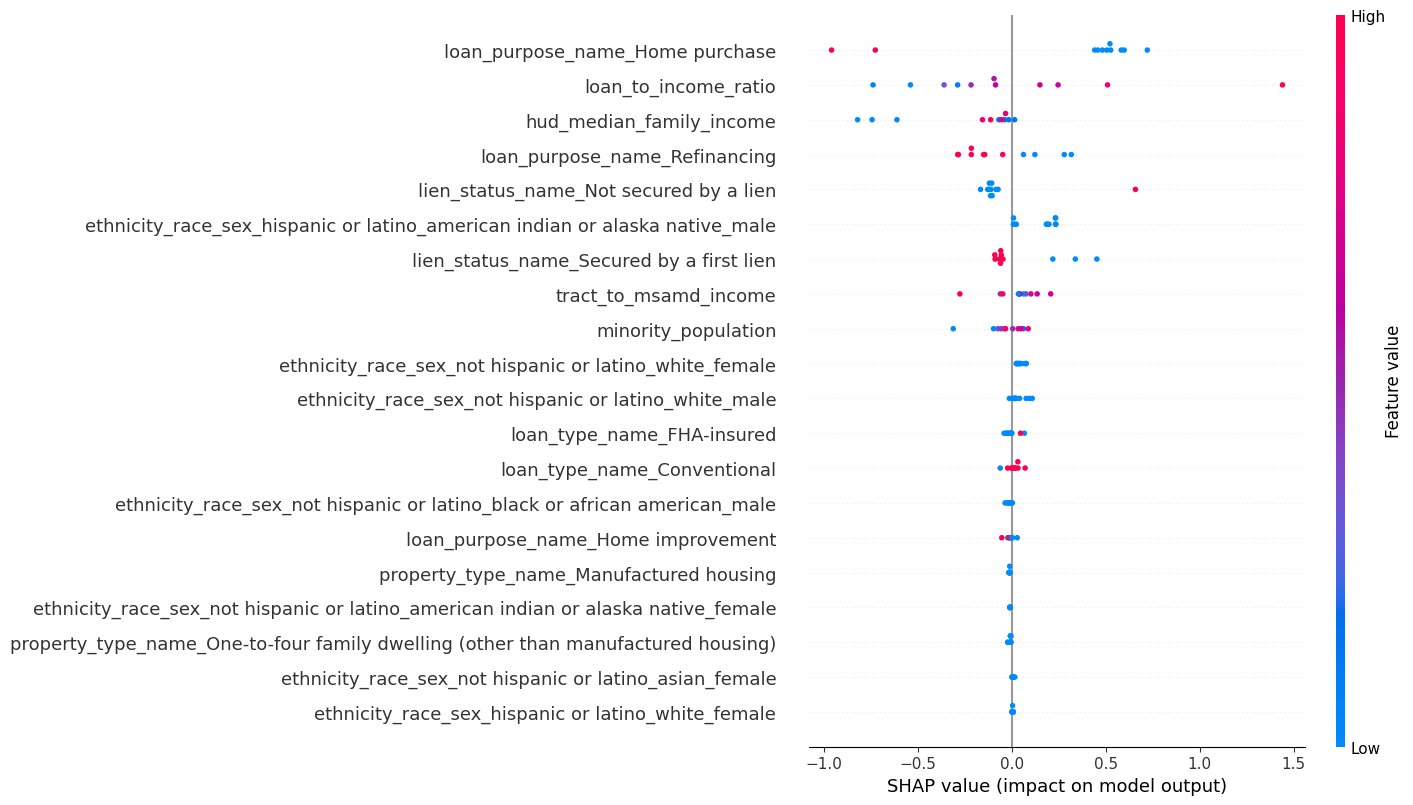

In [ ]:
for group_name, group_data in grouped:
    print(f"Generating SHAP Summary plot for group: {group_name}")

    # Getting the subset of the data for this intersectional group
    X_group = X_test.loc[group_data.index]

    # Subsetting the SHAP values for this group
    shap_values_group = shap_values[group_data.index]

    # Generating the SHAP summary plot for the entire group
    shap.summary_plot(shap_values_group, X_group, feature_names=X_test.columns)

In [ ]:
# ALTERNATIVE TO Summary VALUES pere group SINCE SOME OF the charts were showing distorted display.
for group_name, group_data in grouped:
    print(f"Generating SHAP Custom Summary plot for group: {group_name}")

    # Getting the subset of the data for this intersectional group
    X_group = X_test.loc[group_data.index]

    # Subsetting the SHAP values for this group
    shap_values_group = shap_values[group_data.index]

    # Calculating mean absolute SHAP values for the group
    mean_abs_shap = np.abs(shap_values_group).mean(axis=0)

    # Creating a DataFrame with feature names and mean absolute SHAP values
    shap_importance = pd.DataFrame({
        'feature': X_test.columns,
        'importance': mean_abs_shap
    })

    # Sorting df by importance
    shap_importance_sorted = shap_importance.sort_values(by='importance', ascending=False)

    # Plotting the top 20 features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=shap_importance_sorted.head(20))
    plt.title(f'Top 20 Feature Importances for Group: {group_name}')
    plt.tight_layout()
    plt.show()

## J.4) Summary per group (average)

In [ ]:
for group_name, group_data in grouped:
    print(f"Generating SHAP Waterfall plot for group: {group_name}")

    # Getting the subset of the data for this intersectional group
    X_group = X_test.loc[group_data.index]

    # Subsetting the SHAP values for this group
    shap_values_group = shap_values[group_data.index] # This bit ensure that SHAP values match X_group

    # Calculating the average SHAP values for the group
    avg_shap_values = shap_values_group.mean(axis=0)

    # Generating the SHAP waterfall plot for the average prediction Mind that is for the AVG!
    shap.waterfall_plot(
        shap.Explanation(
            values=avg_shap_values,  # Average SHAP values for the group
            base_values=explainer.expected_value,  # Base value for the SHAP model
            data=X_group.mean(axis=0),  # Average input data for the group
            feature_names=X_test.columns  # Feature names
        )
    )


Output hidden; open in https://colab.research.google.com to view.